In [1]:
"""Run the simulation for a simple two-airport network."""
import os
from itertools import combinations

import click
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns
import torch
import tqdm

import bayes_air.utils.dataloader as ba_dataloader
import wandb
from bayes_air.model import air_traffic_network_model
from bayes_air.network import NetworkState
from bayes_air.schedule import parse_schedule

In [60]:
# Load the dataset
top_n = 10
df = pd.read_pickle("../../data/wn_data_clean.pkl")
df = ba_dataloader.top_N_df(df, top_n)
nominal_df, disrupted_df = ba_dataloader.split_nominal_disrupted_data(df)
nominal_dfs = ba_dataloader.split_by_date(nominal_df)
disrupted_dfs = ba_dataloader.split_by_date(disrupted_df)

In [67]:
print(f"# nominal days: {len(nominal_dfs)}")
print(f"# disrupted days: {len(disrupted_dfs)}")
n_failure = 2
list(range(10))[1:1+2 * n_failure:2]

# nominal days: 18
# disrupted days: 10


[1, 3]

100%|██████████| 15/15 [00:00<00:00, 1300.18it/s]

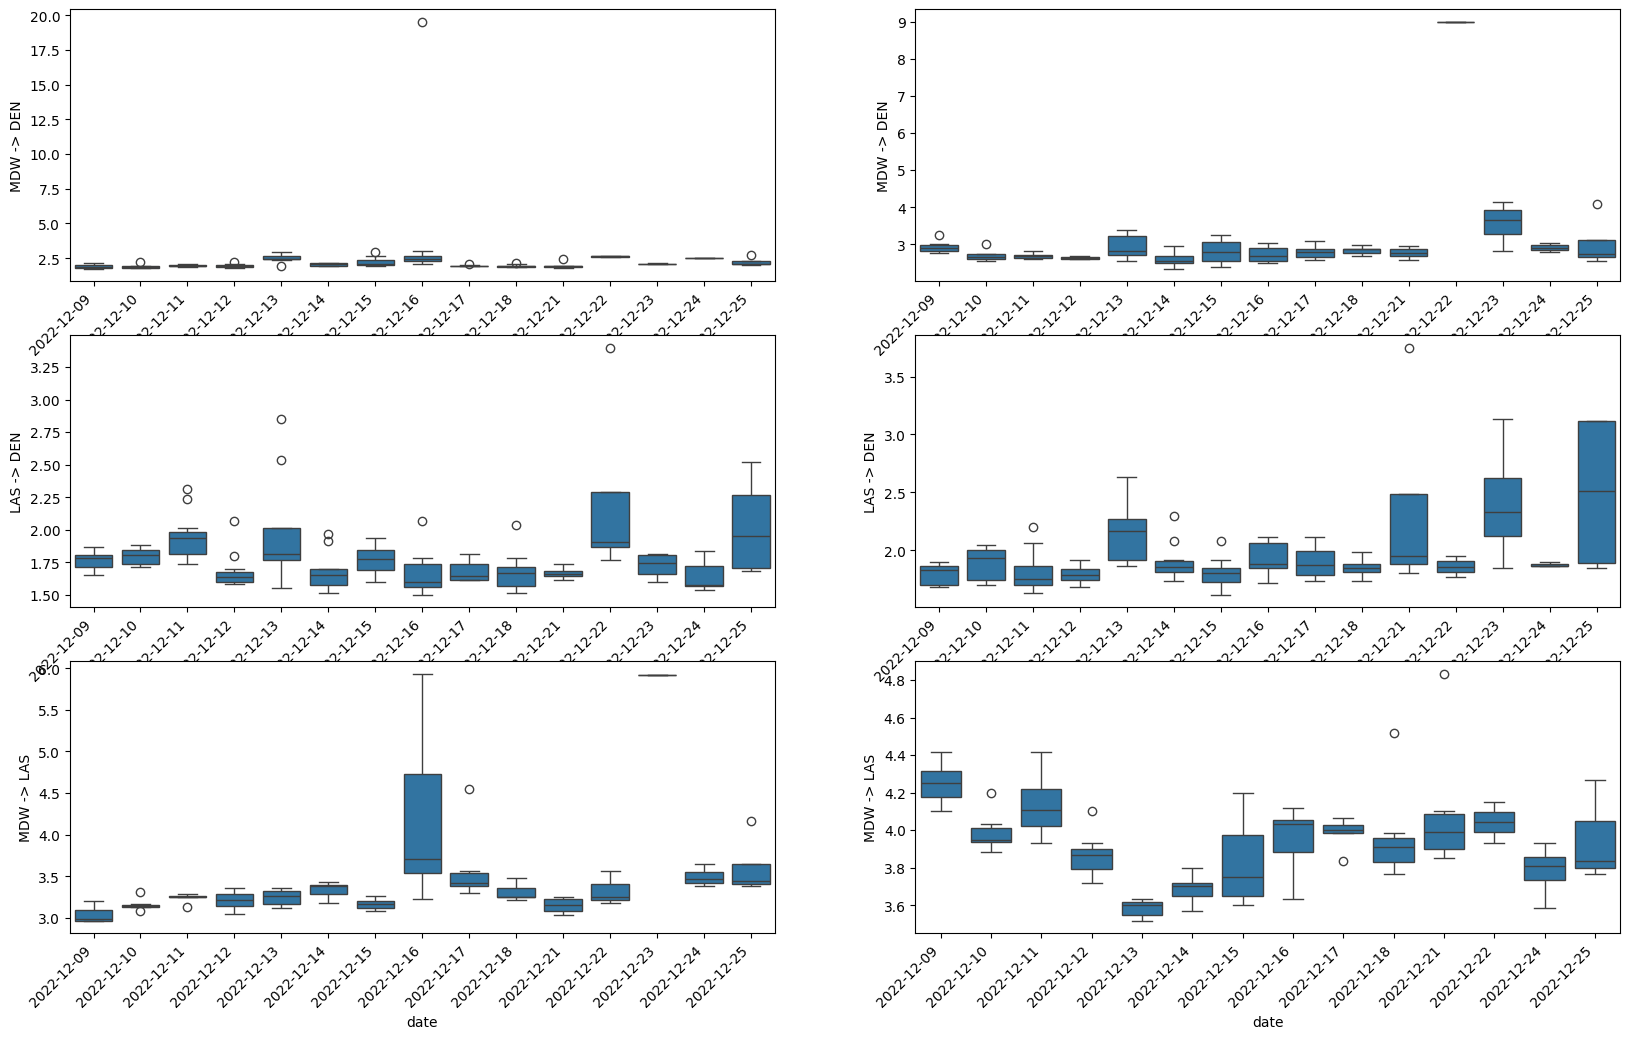

In [51]:
# Get some summary statistics for each day

# Get the travel times for each day
travel_time_dfs = []
for day in tqdm.tqdm(nominal_dfs[-10:] + disrupted_dfs[:5]):
    date = day["date"]
    origin = day["origin_airport"]
    destination = day["destination_airport"]
    travel_times = day["actual_arrival_time"] - day["actual_departure_time"]
    not_cancelled_mask = ~day["cancelled"]
    travel_time_dfs.append(
        pd.DataFrame(
            {
                "date": date[not_cancelled_mask],
                "origin_airport": origin[not_cancelled_mask],
                "destination_airport": destination[not_cancelled_mask],
                "travel_time": travel_times[not_cancelled_mask],
            }
        )
    )
travel_time_df = pd.concat(travel_time_dfs)

# Get the list of unique OD pairs, regardless of order
od_pairs = travel_time_df[["origin_airport", "destination_airport"]].drop_duplicates()
od_pairs = set([tuple(sorted([row["origin_airport"], row["destination_airport"]])) for _, row in od_pairs.iterrows()])
n_od_pairs = len(od_pairs)
fig, axs = plt.subplots(n_od_pairs, 2, figsize=(20, 4 * n_od_pairs))
for i, pair in enumerate(od_pairs):
    forward_ax = axs[i, 0]
    reverse_ax = axs[i, 1]
    
    # Get travel times from origin to destination
    forward_df = travel_time_df[
        (travel_time_df["origin_airport"] == pair[0])
        & (travel_time_df["destination_airport"] == pair[1])
    ]
    sns.boxplot(
        data=forward_df,
        x="date",
        y="travel_time",
        ax=forward_ax,
    )
    forward_ax.set_ylabel(f"{pair[0]} -> {pair[1]}")
    forward_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
    forward_ax.set_xticks(forward_ax.get_xticks())
    forward_ax.set_xticklabels(forward_ax.get_xticklabels(), rotation=45, ha='right')

    # Get travel times from destination to origin
    reverse_df = travel_time_df[
        (travel_time_df["origin_airport"] == pair[1])
        & (travel_time_df["destination_airport"] == pair[0])
    ]
    sns.boxplot(
        data=reverse_df,
        x="date",
        y="travel_time",
        ax=reverse_ax,
    )
    reverse_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
    reverse_ax.set_xticks(reverse_ax.get_xticks())
    reverse_ax.set_xticklabels(reverse_ax.get_xticklabels(), rotation=45, ha='right')

100%|██████████| 28/28 [00:00<00:00, 4526.52it/s]


Text(0, 0.5, 'Percent cancelled')

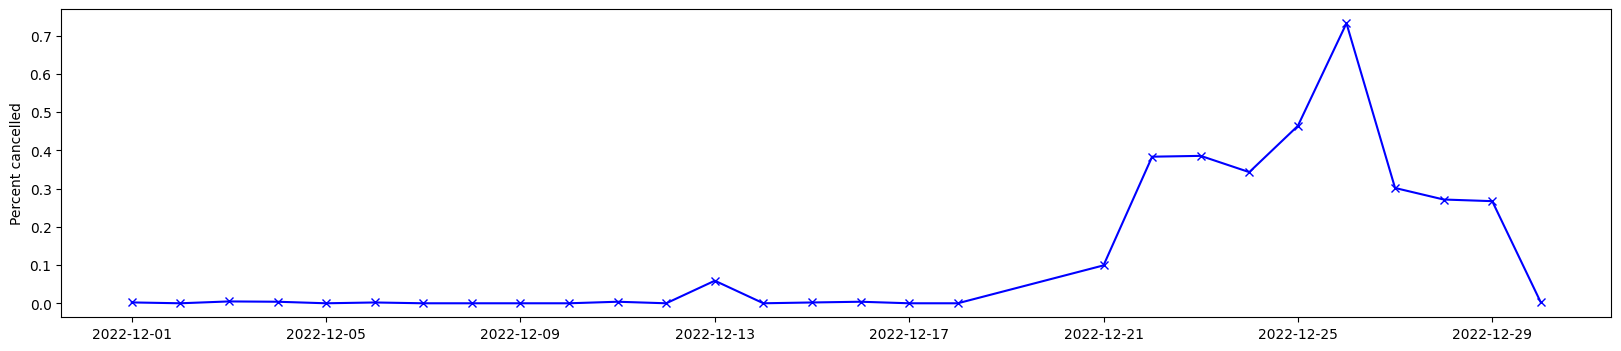

In [61]:
# Plot number of cancellations for each day
dates = []
pct_cancelled = []
for day in tqdm.tqdm(nominal_dfs + disrupted_dfs):
    dates.append(day["date"].iloc[0])
    pct_cancelled.append(day["cancelled"].mean())

fig, ax = plt.subplots(figsize=(20, 4))
ax.plot(dates, pct_cancelled, "bx-")
ax.set_ylabel("Percent cancelled")